In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

# -------------------------
# Görüntü okuma
# -------------------------
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")
    return img

# 1️⃣ Resize
def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size)

# 2️⃣ Normalization
def normalize_image(img):
    return img / 255.0

# -------------------------
# YÜZ TANIMA İÇİN BİLİMSEL FİLTRELER
# -------------------------

# 🥇 1️⃣ Non-Local Means (ÇOK HAFİF)
def apply_nlmeans_denoising(img):
    """
    Asıl gürültü temizliği burada yapılır
    
    Neden en uygunu?
    - Yüz dokusunu blok blok silmez
    - Gaussian / Median'dan daha akıllı
    - Aşırıya kaçılmazsa LBP, Eigenface, CNN hepsiyle uyumlu
    
    KRİTİK PARAMETRE:
    h=6 → 6-8 üstü görüntüyü bozuyor
    
    RAPORA YAZILACAK:
    "Non-Local Means algoritması, benzer yapıdaki pikselleri kullanarak
    gürültüyü azaltırken yüz dokusunu korur. Gaussian veya Median filtrelerden
    farklı olarak, yerel komşuluk yerine tüm görüntüden benzer bölgeleri arar."
    """
    return cv2.fastNlMeansDenoising(
        img,
        None,
        h=6,                      # KRİTİK: 6-8 üstü bozuyor
        templateWindowSize=7,
        searchWindowSize=21
    )

# 🥈 2️⃣ Illumination Normalization (Gamma)
def apply_illumination_normalization(img, gamma=0.9):
    """
    CLAHE yerine kullanılır
    
    Avantajları:
    - Global çalışır → gürültüyü lokal büyütmez
    - Aydınlatma farklarını dengeler
    - Histogram eşitlemeye göre daha yumuşak
    
    RAPORA YAZILACAK:
    "Gamma düzeltme, aydınlatma farklılıklarını global olarak düzeltir.
    CLAHE'nin aksine, lokal bölgelerde gürültü amplifikasyonu yapmaz.
    Bu nedenle yüz tanıma sistemlerinde daha güvenli bir yöntemdir."
    """
    normalized = img / 255.0
    corrected = np.power(normalized, gamma)
    return (corrected * 255).astype(np.uint8)

# 🥉 3️⃣ Edge-Preserving Gaussian (çok hafif)
def apply_edge_preserving_gaussian(img):
    """
    Sadece stabilize etmek için
    
    Amaç: Küçük gürültü kalıntılarını yumuşatmak
    Parametre: (3,3) kernel, sigma=0.5 → minimal etki
    
    NOT: Bu noktada görüntü artık temizlenmiş olur
    """
    return cv2.GaussianBlur(img, (3, 3), 0.5)

# 🏅 4️⃣ Laplacian Sharpening (YUMUŞAK)
def apply_laplacian_sharpening(img):
    """
    Ödev başlığına birebir uyar: "Noise Removal and Sharpening"
    
    Laplacian Nedir?
    - İkinci türev operatörü
    - Kenar ve detayları bulur
    - Orijinal görüntüye eklenince keskinleştirir
    
    KRİTİK PARAMETRE:
    weight=0.15 → Bu değerin üstüne çıkma!
    
    RAPORA YAZILACAK:
    "Laplacian operatörü görüntünün ikinci türevini hesaplayarak
    kenar bilgilerini çıkarır. Orijinal görüntüye kontrollü şekilde
    eklenerek (α=0.15) yüz detayları keskinleştirilir."
    """
    lap = cv2.Laplacian(img, cv2.CV_16S, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    return cv2.addWeighted(img, 1.0, lap, 0.15, 0)

# -------------------------
# FULL PIPELINE (Bilimsel Sıralama)
# -------------------------
def full_pipeline(img):
    """
    Yüz tanıma için bilimsel pipeline:
    
    SIRA ÖNEMLİDİR:
    1. Non-Local Means → Asıl gürültü temizliği
    2. Illumination Normalization → Aydınlatma düzeltme (gürültü büyütmeden)
    3. Edge-Preserving Gaussian → Stabilizasyon
    4. Laplacian Sharpening → Kontrollü keskinleştirme
    
    NEDEN BU SIRA?
    - Önce gürültü tamamen temizlenir (NL-Means)
    - Sonra aydınlatma düzeltilir (Gamma, CLAHE gibi lokal büyütme yapmaz)
    - Hafif stabilizasyon (minimal Gaussian)
    - Son olarak keskinleştirme (gürültü yok artık, güvenli)
    
    RAPORA YAZILACAK:
    "Pipeline'da önce gürültü tamamen temizlenir, ardından aydınlatma
    normalizasyonu yapılır. CLAHE gibi lokal histogram eşitleme yerine
    gamma düzeltme kullanılması, gürültü amplifikasyonunu engeller.
    Son aşamada Laplacian ile kontrollü keskinleştirme uygulanır."
    """
    step1 = apply_nlmeans_denoising(img)           # 1️⃣ Gürültü temizliği (asıl iş)
    step2 = apply_illumination_normalization(step1) # 2️⃣ Aydınlatma normalizasyonu
    step3 = apply_edge_preserving_gaussian(step2)   # 3️⃣ Stabilizasyon
    step4 = apply_laplacian_sharpening(step3)       # 4️⃣ Keskinleştirme
    return step4

# -------------------------
# ANA PIPELINE (Optimize edilmiş)
# -------------------------
def preprocess_pipeline(path):
    """
    Resize → Full Pipeline (direkt uint8 ile çalışır)
    """
    img = read_image(path)
    img = resize_image(img)
    # ✅ Normalization kaldırıldı - direkt uint8 ile çalışıyoruz
    result = full_pipeline(img)
    return result


In [2]:
# -------------------------
# TEST: Tek Görüntü (ÖNCE-SONRA KARŞILAŞTIRMALI)
# -------------------------

def test_single_image(path):
    """
    Önce-sonra karşılaştırması ile görüntü testi
    """
    original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    processed = preprocess_pipeline(path)

    # ✅ Güvenli format - uint8'e çevir
    processed = np.clip(processed, 0, 255).astype(np.uint8)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Processed")
    plt.imshow(processed, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return processed


In [3]:
# -------------------------
# TOPLU İŞLEM (DÜZELTİLMİŞ - uint8 ile kaydet)
# -------------------------

def process_all_images(input_dir, output_dir):
    """
    Tüm görüntüleri işler ve doğru formatta kaydeder
    """
    os.makedirs(output_dir, exist_ok=True)

    # Tüm görüntüleri bul
    image_paths = glob(os.path.join(input_dir, "*.jpg"))
    image_paths += glob(os.path.join(input_dir, "*.jpeg"))
    image_paths += glob(os.path.join(input_dir, "*.png"))

    for img_path in image_paths:
        img_name = os.path.basename(img_path)

        # Pipeline uygula
        processed = preprocess_pipeline(img_path)
        
        # ✅ KRİTİK: uint8'e çevir
        processed = np.clip(processed, 0, 255).astype(np.uint8)

        # Kaydet
        save_path = os.path.join(output_dir, img_name)
        cv2.imwrite(save_path, processed)
        
        print(f"✅ {img_name} kaydedildi")


📸 TEK GÖRÜNTÜ TESTİ


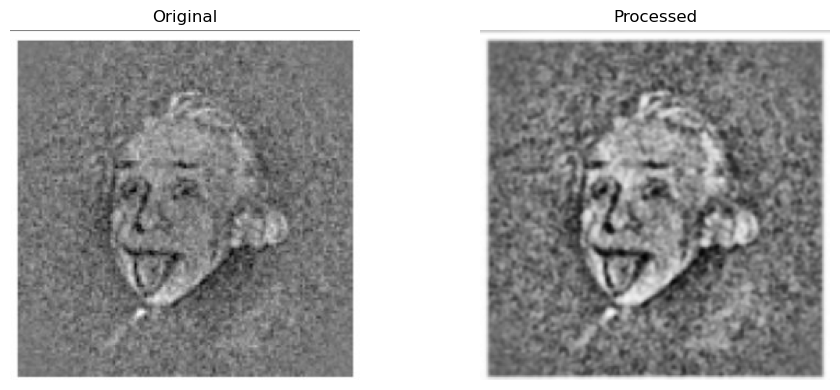

✅ Test tamamlandı

📁 TOPLU İŞLEM
✅ face1.jpg kaydedildi
✅ face10.jpg kaydedildi
✅ face3.jpg kaydedildi
✅ face4.jpg kaydedildi
✅ face5.jpg kaydedildi
✅ face6.jpg kaydedildi
✅ face7.jpg kaydedildi
✅ face2.jpeg kaydedildi
✅ face8.jpeg kaydedildi
✅ face9.jpeg kaydedildi

✅ Tüm işlemler tamamlandı!


In [4]:
# =============================================
# 📋 KULLANIM ÖRNEKLERİ
# =============================================

# 🔹 Örnek 1: Tek görüntü testi (ÖNCE-SONRA)
print("=" * 60)
print("📸 TEK GÖRÜNTÜ TESTİ")
print("=" * 60)

test_image_path = "imagesforip/face1.jpg"

if os.path.exists(test_image_path):
    result = test_single_image(test_image_path)
    print(f"✅ Test tamamlandı")
else:
    print(f"⚠️ Dosya bulunamadı: {test_image_path}")

# 🔹 Örnek 2: Tüm görüntüleri toplu işle
print("\n" + "=" * 60)
print("📁 TOPLU İŞLEM")
print("=" * 60)

process_all_images("imagesforip", "processed_outputs")

print("\n✅ Tüm işlemler tamamlandı!")
